In [1]:
%matplotlib inline

# 自動駕駛街景分割(pytorch)

### 測試於pytorch 1.0

<img src="../Data/autodrive_train/orign_images/0001TP_006750.png",width=480,height=360>
<img src="../Data/autodrive_train/masks/0001TP_006750_L.png",width=480,height=360>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pylab
import PIL
from PIL import Image
import glob
import threading
import random
import math
import datetime
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


# 是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
images = glob.glob('../Data/autodrive_train/orign_images/' + '*.png')
labels = ['../Data/autodrive_train/masks/' + os.path.basename(i)[:-4] + '_L.png' for i in images]
print(len(images))
print(images[:5])

701
['../Data/autodrive_train/orign_images\\0001TP_006690.png', '../Data/autodrive_train/orign_images\\0001TP_006720.png', '../Data/autodrive_train/orign_images\\0001TP_006750.png', '../Data/autodrive_train/orign_images\\0001TP_006780.png', '../Data/autodrive_train/orign_images\\0001TP_006810.png']


In [4]:
print(open("label_colors.txt").readlines())

['Void\t0 0 0\n', 'Building\t128 0 0\n', 'grass\t0 128 0\n', 'Tree\t128 128 0\n', 'cow\t0 0 128\n', 'horse\t128 0 128\n', 'sheep\t0 128 128\n', 'Sky\t128 128 128\n', 'mountain\t64 0 0\n', 'aeroplane\t192 0 0\n', 'water\t64 128 0\n', 'face\t192 128 0\n', 'Car\t64 0 128\n', 'Archway\t192 0 128\n', 'flower\t64 128 128\n', 'SignSymbol\t192 128 128\n', 'bird\t0 64 0\n', 'book\t128 64 0\n', 'chair\t0 192 0\n', 'motorbike\t128 192 0\n', 'person\t0 64 128\n', 'Road\t128 64 128\n', 'cat\t0 192 128\n', 'dog\t128 192 128\n', 'Pedestrian\t64 64 0\n', 'boat\t192 64 0\n', 'Wall\t64 192 0\n', 'VegetationMisc\t192 192 0\n', 'Fence\t64 64 128\n', 'Train\t192 64 128\n', 'ParkingBlock\t64 192 128\n', 'Column_Pole\t192 192 128\n', 'TrafficCone\t0 0 64\n', 'unused\t128 0 64\n', 'Bridge\t0 128 64\n', 'Misc_Text\t128 128 64\n', 'Sidewalk\t0 0 192\n', 'LaneMkgsDriv\t128 0 192\n', 'Bicyclist\t0 128 192\n', 'RoadShoulder\t128 128 192\n', 'Tunnel\t64 0 64\n', 'LaneMkgsNonDriv\t192 0 64\n', 'Animal\t64 128 64\n',

In [5]:
def parse_code(l):
    if len(l.strip().split("\t")) == 2:
        a, b = l.replace('\t\t','\t').strip().split("\t")
        return tuple(int(i) for i in b.split(' '))[::-1], a

label_codes, label_names = zip(*[parse_code(l) for l in open("label_colors.txt")])
label_codes, label_names = list(label_codes), list(label_names)

for i in range(len(label_codes)):
    print(str(label_codes[i])+' '+label_names[i])

(0, 0, 0) Void
(0, 0, 128) Building
(0, 128, 0) grass
(0, 128, 128) Tree
(128, 0, 0) cow
(128, 0, 128) horse
(128, 128, 0) sheep
(128, 128, 128) Sky
(0, 0, 64) mountain
(0, 0, 192) aeroplane
(0, 128, 64) water
(0, 128, 192) face
(128, 0, 64) Car
(128, 0, 192) Archway
(128, 128, 64) flower
(128, 128, 192) SignSymbol
(0, 64, 0) bird
(0, 64, 128) book
(0, 192, 0) chair
(0, 192, 128) motorbike
(128, 64, 0) person
(128, 64, 128) Road
(128, 192, 0) cat
(128, 192, 128) dog
(0, 64, 64) Pedestrian
(0, 64, 192) boat
(0, 192, 64) Wall
(0, 192, 192) VegetationMisc
(128, 64, 64) Fence
(128, 64, 192) Train
(128, 192, 64) ParkingBlock
(128, 192, 192) Column_Pole
(64, 0, 0) TrafficCone
(64, 0, 128) unused
(64, 128, 0) Bridge
(64, 128, 128) Misc_Text
(192, 0, 0) Sidewalk
(192, 0, 128) LaneMkgsDriv
(192, 128, 0) Bicyclist
(192, 128, 128) RoadShoulder
(64, 0, 64) Tunnel
(64, 0, 192) LaneMkgsNonDriv
(64, 128, 64) Animal
(64, 128, 192) Child
(192, 0, 64) CartLuggagePram
(192, 0, 192) MotorcycleScooter
(192

In [6]:
img_h =64
img_w = 64
num_classes =len(label_codes)


#開啟圖片，並且縮放至64*64(原圖是960*720)
def open_image(img):
    x=np.array(Image.open(img).resize((img_h,img_w), Image.NEAREST))
    x = x.astype(np.float32).transpose(2,0,1)
    x = np.ascontiguousarray(x)[::-1]
    return x

imgs = np.stack([open_image(i) for i in images])
print(imgs.shape)

lbs = np.stack([open_image(l) for l in labels])
print(lbs.shape)

(701, 3, 64, 64)
(701, 3, 64, 64)


In [7]:
#將圖片向量除以255，讓數值介於0~1之間
imgs = imgs/255.

#計算圖片的平均值與標準差
mean = imgs.mean()
std = imgs.std()
print('平均值:{0},標準差:{1}'.format(mean, std))

#圖片根據平均值與標準差正歸化
imgs-=imgs.mean()
imgs/=imgs.std()

平均值:0.40013885498046875,標準差:0.3020400106906891


In [8]:
#產生索引對類別色彩之間的轉換
code2id = {v: k for k, v in enumerate(label_codes)}
id2code = {k: v for k, v in enumerate(label_codes)}
print(len(label_codes))
num_class=len(label_codes)
code2id

50


{(0, 0, 0): 0,
 (0, 0, 64): 8,
 (0, 0, 128): 1,
 (0, 0, 192): 9,
 (0, 64, 0): 16,
 (0, 64, 64): 24,
 (0, 64, 128): 17,
 (0, 64, 192): 25,
 (0, 128, 0): 2,
 (0, 128, 64): 10,
 (0, 128, 128): 3,
 (0, 128, 192): 11,
 (0, 192, 0): 18,
 (0, 192, 64): 26,
 (0, 192, 128): 19,
 (0, 192, 192): 27,
 (64, 0, 0): 32,
 (64, 0, 64): 40,
 (64, 0, 128): 33,
 (64, 0, 192): 41,
 (64, 64, 0): 48,
 (64, 64, 128): 49,
 (64, 128, 0): 34,
 (64, 128, 64): 42,
 (64, 128, 128): 35,
 (64, 128, 192): 43,
 (128, 0, 0): 4,
 (128, 0, 64): 12,
 (128, 0, 128): 5,
 (128, 0, 192): 13,
 (128, 64, 0): 20,
 (128, 64, 64): 28,
 (128, 64, 128): 21,
 (128, 64, 192): 29,
 (128, 128, 0): 6,
 (128, 128, 64): 14,
 (128, 128, 128): 7,
 (128, 128, 192): 15,
 (128, 192, 0): 22,
 (128, 192, 64): 30,
 (128, 192, 128): 23,
 (128, 192, 192): 31,
 (192, 0, 0): 36,
 (192, 0, 64): 44,
 (192, 0, 128): 37,
 (192, 0, 192): 45,
 (192, 128, 0): 38,
 (192, 128, 64): 46,
 (192, 128, 128): 39,
 (192, 128, 192): 47}

In [9]:
#產生索引對類別色彩之間的轉換
code2id = {v: k for k, v in enumerate(label_codes)}
id2code = {k: v for k, v in enumerate(label_codes)}
label_colours = np.asarray(label_codes)
failed_code = len(label_codes) + 1
n, ch,r, c = imgs.shape

#轉換單張標籤為mask(3*64*64->50*64*64)
def conv_one_label(b_label,num_class=50):
    res = np.zeros((num_class, b_label.shape[1],b_label.shape[2]), 'float32')
    for j in range(b_label.shape[1]):
        for k in range(b_label.shape[2]):
            color=tuple(b_label[:,j,k].tolist())
            if color in code2id:
                try:
                    res[code2id[color], j, k] = 1
                except Exception as e:
                    print(e)
                    print(code2id[color])
                    print(color)
                    res[0, j, k] = 1
            else:
                res[0, j, k] = 1
    return res

#將一個批次做轉換
def conv_all_labels(b_label):
    lblist = []
    for i in range(b_label.shape[0]):
        ls = conv_one_label(b_label[i])
        lblist.append(ls)
    return np.asarray(lblist)

#將向量轉圖片
def array2img(arr: np.ndarray):
    sanitized_img =arr
    if len(arr.shape) > 2:
        if arr.shape[0]>1:
            arr = arr[::-1]
        sanitized_img = np.maximum(0, np.minimum(255, np.transpose(arr, (1, 2, 0))))
        if arr.shape[0]==1:
            sanitized_img =np.squeeze(sanitized_img,-1)
        img = Image.fromarray(sanitized_img.astype(np.uint8))
        return img
    elif  len(arr.shape) == 2:
        img = Image.fromarray(arr.astype(np.int8))
        return img

#將mask轉RGB圖片(50*64*64=>3*64*64)
def decode_labels(masks, num_classes=50):
    global img_w, img_h
    result = []
    for batch in range(masks.shape[0]):
        decode_map = masks[batch]
        decode_map = np.argmax(decode_map, 0).astype(np.float32)
        color_img = np.zeros((img_h, img_w, 3), dtype=np.float32)# * 192
        for k in range(num_classes):
            if k > 0:
                color_img[decode_map == k] = label_colours[k]
        result.append(color_img.transpose(2, 0, 1))
    return np.asarray(result)

#把圖片並列列印出來
def tile_rgb_images(pred, label, truth, row=3, col=3):
    fig = pylab.gcf()
    fig.set_size_inches(col * 2, row * 2)
    pylab.clf()
    pylab.ioff()  # is not None:
    for m in range(row * col):
        pylab.subplot(row, col, m + 1)
        if m % 3 == 0:
            if pred.shape[0] == 1:
                pred = pred[0]
            img = array2img(pred[int(m / 3)]).resize((120,90))
        elif m % 3 == 1:
            if label.shape[0] == 1:
                label = label[0]
            img = array2img(label[int((m - 1) / 3)]).resize((120,90))
        else:
            if truth.shape[0] == 1:
                truth = truth[0]
            img = array2img((truth[int((m - 2) / 3)] * std + mean) * 255).resize((120,90))
        pylab.imshow(img, interpolation="nearest", animated=True)
        pylab.axis("off")

In [10]:
idx=0
idxs=np.arange(len(imgs))
np.random.shuffle(idxs)

def get_next_minibatch(minibatch_size=8):
    global idx,idxs
    features=[]
    masks=[]
    while len(features)<minibatch_size:
        features.append(imgs[idxs[idx]])
        masks.append(lbs[idxs[idx]])
        idx+=1
        if idx>=len(imgs)-1:
            idx=0
            np.random.shuffle(idxs)
    return np.asarray(features),conv_all_labels(np.asarray(masks))
        
    

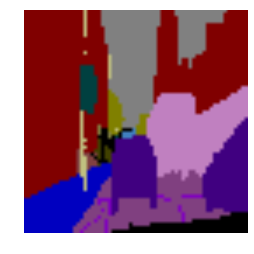

In [11]:
label=array2img(lbs[0])
plt.axis('off')
plt.imshow(label)

(50, 64, 64)
(1, 3, 64, 64)


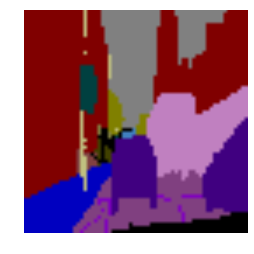

In [12]:
mask=conv_one_label(lbs[0],num_class)
print(mask.shape)
rgb_label=decode_labels(np.asarray([mask]),num_class)
print(rgb_label.shape)
plt.axis('off')
plt.imshow(array2img(rgb_label[0]))

In [14]:
b_img, b_label = get_next_minibatch()
print(b_img.shape)
print(b_label.shape)

(8, 3, 64, 64)
(8, 50, 64, 64)


![autodrive](../Images/tiramisu.jpg)

In [15]:
class DenseLayer(nn.Sequential): 
    def __init__(self, in_channels, growth_rate): 
        super().__init__() 
        self.add_module('norm', nn.BatchNorm2d(in_channels)) 
        self.add_module('relu', nn.ReLU(True)) 
        self.add_module('conv', nn.Conv2d(in_channels, growth_rate, kernel_size=3, stride=1, padding=1, bias=True)) 
        self.add_module('drop', nn.Dropout2d(0.2)) 
    def forward(self, x): 
        return super().forward(x)  

class DenseBlock(nn.Module): 
    def __init__(self, in_channels, growth_rate, n_layers, upsample=False): 
        super().__init__() 
        self.upsample = upsample 
        self.layers = nn.ModuleList([DenseLayer( 
            in_channels + i*growth_rate, growth_rate) 
            for i in range(n_layers)]) 
    def forward(self, x): 
        if self.upsample: 
            new_features = [] 
            #we pass all previous activations into each dense layer normally 
            #But we only store each dense layer's output in the new_features array 
            for layer in self.layers: 
                out = layer(x) 
                x = torch.cat([x, out], 1) 
                new_features.append(out) 
            return torch.cat(new_features,1) 
        else: 
            for layer in self.layers: 
                out = layer(x) 
                x = torch.cat([x, out], 1) # 1 = channel axis 
            return x 

class TransitionDown(nn.Sequential): 
    def __init__(self, in_channels): 
        super().__init__() 
        self.add_module('norm', nn.BatchNorm2d(num_features=in_channels)) 
        self.add_module('relu', nn.ReLU(inplace=True)) 
        self.add_module('conv', nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0, bias=True)) 
        self.add_module('drop', nn.Dropout2d(0.2)) 
        self.add_module('maxpool', nn.MaxPool2d(2)) 
    def forward(self, x): 
        return super().forward(x) 
 
 
 
 
class TransitionUp(nn.Module): 
    def __init__(self, in_channels, out_channels): 
        super().__init__() 
        self.convTrans = nn.ConvTranspose2d( 
            in_channels=in_channels, out_channels=out_channels, 
            kernel_size=3, stride=2, padding=0, bias=True) 
    def forward(self, x, skip): 
        out = self.convTrans(x) 
        out = center_crop(out, skip.size(2), skip.size(3)) 
        out = torch.cat([out, skip], 1) 
        return out 

class Bottleneck(nn.Sequential): 
    def __init__(self, in_channels, growth_rate, n_layers): 
        super().__init__() 
        self.add_module('bottleneck', DenseBlock( in_channels, growth_rate, n_layers, upsample=True)) 
    def forward(self, x): 
        return super().forward(x) 

 
 
def center_crop(layer, max_height, max_width): 
    _, _, h, w = layer.size() 
    xy1 = (w - max_width) // 2 
    xy2 = (h - max_height) // 2 
    return layer[:, :, xy2:(xy2 + max_height), xy1:(xy1 + max_width)]



class FCDenseNet(nn.Module):
    def __init__(self, in_channels=3, down_blocks=(5,5,5,5,5),
                 up_blocks=(5,5,5,5,5), bottleneck_layers=5,
                 growth_rate=16, out_chans_first_conv=48, n_classes=12):
        super().__init__()
        self.down_blocks = down_blocks
        self.up_blocks = up_blocks
        cur_channels_count = 0
        skip_connection_channel_counts = []

        ## First Convolution ##

        self.add_module('firstconv', nn.Conv2d(in_channels=in_channels,
                  out_channels=out_chans_first_conv, kernel_size=3,
                  stride=1, padding=1, bias=True))
        cur_channels_count = out_chans_first_conv

        #####################
        # Downsampling path #
        #####################

        self.denseBlocksDown = nn.ModuleList([])
        self.transDownBlocks = nn.ModuleList([])
        for i in range(len(down_blocks)):
            self.denseBlocksDown.append(
                DenseBlock(cur_channels_count, growth_rate, down_blocks[i]))
            cur_channels_count += (growth_rate*down_blocks[i])
            skip_connection_channel_counts.insert(0,cur_channels_count)
            self.transDownBlocks.append(TransitionDown(cur_channels_count))

        #####################
        #     Bottleneck    #
        #####################

        self.add_module('bottleneck',Bottleneck(cur_channels_count,
                                     growth_rate, bottleneck_layers))
        prev_block_channels = growth_rate*bottleneck_layers
        cur_channels_count += prev_block_channels

        #######################
        #   Upsampling path   #
        #######################

        self.transUpBlocks = nn.ModuleList([])
        self.denseBlocksUp = nn.ModuleList([])
        for i in range(len(up_blocks)-1):
            self.transUpBlocks.append(TransitionUp(prev_block_channels, prev_block_channels))
            cur_channels_count = prev_block_channels + skip_connection_channel_counts[i]

            self.denseBlocksUp.append(DenseBlock(
                cur_channels_count, growth_rate, up_blocks[i],
                    upsample=True))
            prev_block_channels = growth_rate*up_blocks[i]
            cur_channels_count += prev_block_channels

        ## Final DenseBlock ##

        self.transUpBlocks.append(TransitionUp(
            prev_block_channels, prev_block_channels))
        cur_channels_count = prev_block_channels + skip_connection_channel_counts[-1]

        self.denseBlocksUp.append(DenseBlock(
            cur_channels_count, growth_rate, up_blocks[-1],
                upsample=False))
        cur_channels_count += growth_rate*up_blocks[-1]

        ## Softmax ##

        self.finalConv =nn.Conv2d(cur_channels_count, n_classes, 1)

    def forward(self, x):
        out = self.firstconv(x)

        skip_connections = []
        for i in range(len(self.down_blocks)):
            out = self.denseBlocksDown[i](out)
            skip_connections.append(out)
            out = self.transDownBlocks[i](out)

        out = self.bottleneck(out)
        for i in range(len(self.up_blocks)):
            skip = skip_connections.pop()
            out = self.transUpBlocks[i](out, skip)
            out = self.denseBlocksUp[i](out)

        out = self.finalConv(out)
        return out



def tiramitsu(n_classes):
    return FCDenseNet(
        in_channels=3, down_blocks=(4,5,7,10,12),
        up_blocks=(12,10,7,5,4), bottleneck_layers=15,
        growth_rate=16, out_chans_first_conv=32, n_classes=n_classes)


def weights_init(m): 
    if isinstance(m, nn.Conv2d): 
        nn.init.kaiming_uniform_(m.weight) 
        m.bias.data.zero_() 


In [19]:
def save_weights(model, epoch, loss, err):
    weights_fname = 'weights-%d-%.3f-%.3f.pth' % (epoch, loss, err)
    weights_fpath = "Models/{0}".format(weights_fname)
    torch.save({
            'startEpoch': epoch,
            'loss':loss,
            'error': err,
            'state_dict': model.state_dict()
        }, weights_fpath)

    
    
def load_weights(model, fpath):
    print("loading weights '{}'".format(fpath))
    weights = torch.load(fpath)
    startEpoch = weights['startEpoch']
    model.load_state_dict(weights['state_dict'])
    print("loaded weights (lastEpoch {}, loss {}, error {})"
          .format(startEpoch-1, weights['loss'], weights['error']))
    return startEpoch



def error(preds, targets):
    assert preds.size() == targets.size()
    bs,h,w = preds.size()
    n_pixels = bs*h*w
    incorrect = preds.ne(targets).cpu().sum()
    err = incorrect/n_pixels
    return round(err,5)


def iou(pred, target, n_classes = 50):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(1, n_classes):  # This goes from 1:n_classes-1 -> class "0" is ignored
        pred_inds = pred == cls
        target_inds = target == cls
        pred_inds=pred_inds.cpu().detach().numpy()
        target_inds=target_inds.cpu().detach().numpy()
        
        intersection = np.equal(pred_inds,target_inds).astype(np.float32).sum()  # Cast to long to prevent overflows
        union =  np.greater(pred_inds+target_inds,0).astype(np.float32).sum() - intersection
        if union == 0:
            ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
            ious.append(float(intersection) / float(max(union, 1)))
    return np.array(ious)




In [16]:
def dice_loss(input,target):
    """
    input is a torch variable of size BatchxnclassesxHxW representing log probabilities for each class
    target is a 1-hot representation of the groundtruth, shoud have same size as the input
    """
    assert input.size() == target.size(), "Input sizes must be equal."
    assert input.dim() == 4, "Input must be a 4D Tensor."
    uniques=np.unique(target.cpu().detach().numpy())
    assert set(list(uniques))<=set([0,1]), "target must only contain zeros and ones"

    probs=F.softmax(input)
    num=probs*target#b,c,h,w--p*g
    num=torch.sum(num,dim=3)#b,c,h
    num=torch.sum(num,dim=2)
    

    den1=probs*probs#--p^2
    den1=torch.sum(den1,dim=3)#b,c,h
    den1=torch.sum(den1,dim=2)
    

    den2=target*target#--g^2
    den2=torch.sum(den2,dim=3)#b,c,h
    den2=torch.sum(den2,dim=2)#b,c
    

    dice=2*(num/(den1+den2))
    dice_eso=dice[:,1:]#we ignore bg dice val, and take the fg

    dice_total=-1*torch.sum(dice_eso)/dice_eso.size(0)#divide by batch_sz

    return dice_total

In [17]:
minibatch_size =8
num_epochs = 10
learning_rate = 0.000125  # 學習速率

model = tiramitsu(n_classes=50).to(device)
model.apply(weights_init)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-4) 
criterion=dice_loss

In [20]:
print('epoch start')
for epoch in range(num_epochs):
    mbs=0
    trn_loss = 0 
    trn_error = 0 
    while mbs <100:
        b_img, b_label =  get_next_minibatch(minibatch_size)
        input, target = torch.from_numpy(b_img),torch.from_numpy(b_label)
        input, target = Variable(input).to(device), Variable(target).to(device)
        output = model(input)
        loss=criterion(output ,target)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trn_loss += loss.item()
        
        err=np.mean(np.equal(np.argmax(output.cpu().detach().numpy(),0),np.argmax(target.cpu().detach().numpy(),0)).astype(np.uint8))
        trn_error +=(1-err)
       

        if mbs%5==0 or mbs<=5:
            print("Epoch: {}/{} ".format(epoch+1, num_epochs),
                                      "Step: {} ".format(mbs),
                                      "Loss: {:.4f}...".format(loss.item()),
                                      "accuracy: {:.4f}...".format(err))
       
        mbs+=1
    trn_loss /= 100 
    trn_error /= 100 
    save_weights(model, epoch, trn_loss, trn_error)
   

epoch start


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/10  Step: 0  Loss: -4.6973... accuracy: 0.1400...
Epoch: 1/10  Step: 1  Loss: -4.8119... accuracy: 0.1598...
Epoch: 1/10  Step: 2  Loss: -4.8861... accuracy: 0.1223...
Epoch: 1/10  Step: 3  Loss: -4.9564... accuracy: 0.1851...
Epoch: 1/10  Step: 4  Loss: -5.2286... accuracy: 0.0998...
Epoch: 1/10  Step: 5  Loss: -4.3196... accuracy: 0.1832...
Epoch: 1/10  Step: 10  Loss: -4.7040... accuracy: 0.1423...
Epoch: 1/10  Step: 15  Loss: -5.1326... accuracy: 0.1304...
Epoch: 1/10  Step: 20  Loss: -5.6494... accuracy: 0.1520...
Epoch: 1/10  Step: 25  Loss: -5.2975... accuracy: 0.1465...
Epoch: 1/10  Step: 30  Loss: -4.8873... accuracy: 0.1230...
Epoch: 1/10  Step: 35  Loss: -5.2407... accuracy: 0.1172...
Epoch: 1/10  Step: 40  Loss: -4.7994... accuracy: 0.1236...
Epoch: 1/10  Step: 45  Loss: -5.0445... accuracy: 0.1197...
Epoch: 1/10  Step: 50  Loss: -5.1179... accuracy: 0.0939...
Epoch: 1/10  Step: 55  Loss: -5.1048... accuracy: 0.1864...
Epoch: 1/10  Step: 60  Loss: -5.3570... accura

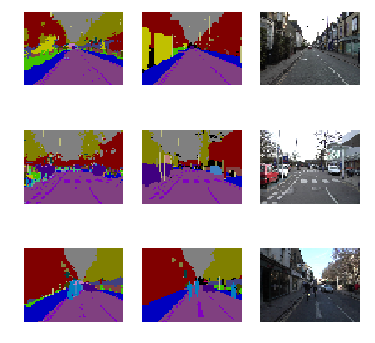

In [21]:
raw_features, raw_labels = get_next_minibatch(4)
input, target = torch.from_numpy(raw_features), torch.from_numpy(raw_labels)
input, target = Variable(input).to(device), Variable(target).to(device)
output = model(input)

e1 = decode_labels(output.cpu().detach().numpy(), num_classes).astype(np.uint8)
l1 = decode_labels(raw_labels, num_classes).astype(np.uint8)
tile_rgb_images(e1, l1, raw_features, row=3, col=3)